In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib

from zipfile import ZipFile
import json
from collections import defaultdict

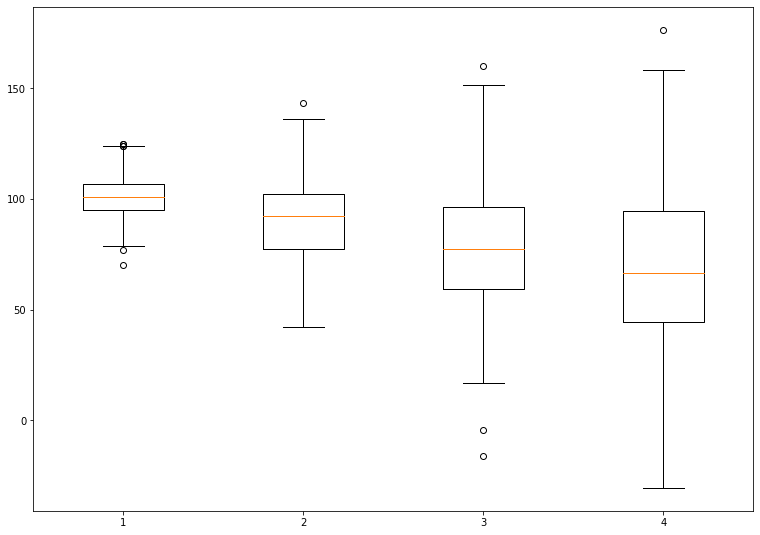

In [3]:
# Creating dataset
np.random.seed(10)
  
data_1 = np.random.normal(100, 10, 200)
data_2 = np.random.normal(90, 20, 200)
data_3 = np.random.normal(80, 30, 200)
data_4 = np.random.normal(70, 40, 200)
data = [data_1, data_2, data_3, data_4]
  
fig = plt.figure(figsize =(10, 7))
  
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
  
# Creating plot
bp = ax.boxplot(data)
  
# show plot
plt.show()

In [3]:
def process_folds(kfolds):
    labels = ['none','sc_guard','oh_verify','cfi_verify']
    result = {}
    for label in labels:
        result[label]=[]
    for fold in kfolds:
        for scores in fold:
            if np.isnan(scores['fscore']):
                continue
            result[scores['label']].append(scores['fscore'])
    return result


def process_results_data(dt, file_path):
    obfuscation = file_path.split('/')[-2].\
        replace('sbb-','').replace('sbb','').replace('-','+').\
        replace('FLAs','CFF').replace('BCF','BC').replace('SUB','IS')
    return {
        'classifier': dt['classifier'],
        'fold_result': process_folds(dt['Kfold_results']),
        'subject_group': dt.get('subject_groups', dt.get('subject_groups_test')),
        'data_size': int(dt['train_size'])+int(dt['test_size']),
        'obfuscation': obfuscation,
        'file_path': file_path
    }


def read_zip_data(zip_path):
    res = []
    with ZipFile(zip_path, 'r') as f_zip:
        for file in f_zip.filelist:
            if 'result.json' in file.filename:
                dt = json.loads(f_zip.read(file))
                res.append(process_results_data(dt, file.filename))
    return res

In [4]:
zip_file_names = {
    'original': 'paperback.zip', 
#     'no_tf_idf': 'paperback_with_no_tf_idf.zip', 
    'ir2vec': 'paperback_ir2vec.zip',
    'tf_idf_plus_ir2vec': 'paperback_ir2vec_plus_tf_idf.zip'
}

results_data = []
zips_path = pathlib.Path('/media/nika/TOSHIBA EXT/')
for category, zip_file_name in zip_file_names.items():
    results_data.append({
        'category': category,
        'results': read_zip_data(zips_path / zip_file_name)
    })

In [5]:
data_results = results_data[0]['results']
results_data[0]['category']

'original'

In [6]:
data_results = results_data[1]['results']
results_data[1]['category']

'ir2vec'

In [7]:
def get_plot_results(results_data, protection, filter_data='mibench-cov'):
    """
        {
            # obfuscation --> results
            'None': {
                'original': [0.98, 0.99, 0.99, ...],
                'no_tf_idf': [],
                'ir2vec': []
            },
            'IS': {
                'original': [...],
                'no_tf_idf': [...],
                'ir2vec': [...]
            },
            'FLA': {
                'original': [...],
                'no_tf_idf': [...],
                'ir2vec': [...]
            }
        }
    """
    plot_results = defaultdict(dict)
    for dt in results_data:
        dataset = dt['category']
        for res in dt['results']:
            obfuscation = res['obfuscation']
            if filter_data not in res['file_path']:
                continue

            plot_results[obfuscation][dataset] = res['fold_result'][protection]
    return plot_results

In [151]:
plot_results = get_plot_results(results_data, 'none')

In [152]:
def median(nums):
    return sorted(nums)[len(nums)//2]


# def median(nums):
#     return sum(nums)/len(nums)

In [153]:
data_labels = sorted(
    plot_results.keys(), 
    key=lambda key: median(plot_results[key]['tf_idf_plus_ir2vec']),
    reverse=True
)
data_values_original = [plot_results[label]['original'] for label in data_labels]
data_values_ir2vec = [plot_results[label]['ir2vec'] for label in data_labels]
data_values_tf_idf_plus_ir2vec = [plot_results[label]['tf_idf_plus_ir2vec'] for label in data_labels]

In [154]:
def draw_plot(data_labels, data_values, title, file_name):    
    data_a, data_b, data_c = data_values
    ticks = data_labels # ['A', 'B', 'C']

    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)
    
    figsize_x = 3 if 'simple' in file_name else 4
    plt.figure(figsize=(len(ticks)//2, figsize_x), dpi=200)

    # bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6)
    # bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)


    bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a))) - 0.15, sym='', widths=0.08)
    bpm = plt.boxplot(data_b, positions=np.array(range(len(data_b))),       sym='', widths=0.08)
    bpr = plt.boxplot(data_c, positions=np.array(range(len(data_c))) + 0.15, sym='', widths=0.08)

    set_box_color(bpl, '#A9A9A9') # colors are from http://colorbrewer2.org/
    set_box_color(bpm, '#228B22')
    set_box_color(bpr, '#FF0000')

    plt.plot([], c='#A9A9A9', label='Original')
    plt.plot([], c='#228B22', label='Ir2Vec')
    plt.plot([], c='#FF0000', label='Original+Ir2Vec')
    plt.legend(loc=4, prop={'size': 6})

    plt.title(title)
    
    plt.xticks(range(0, len(ticks)), ticks, size=6)
    plt.xlim(-0.5, len(ticks))
    plt.ylim(0, 1.1)
    plt.tight_layout()
    
    ax = plt.gca()
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.savefig(file_name)

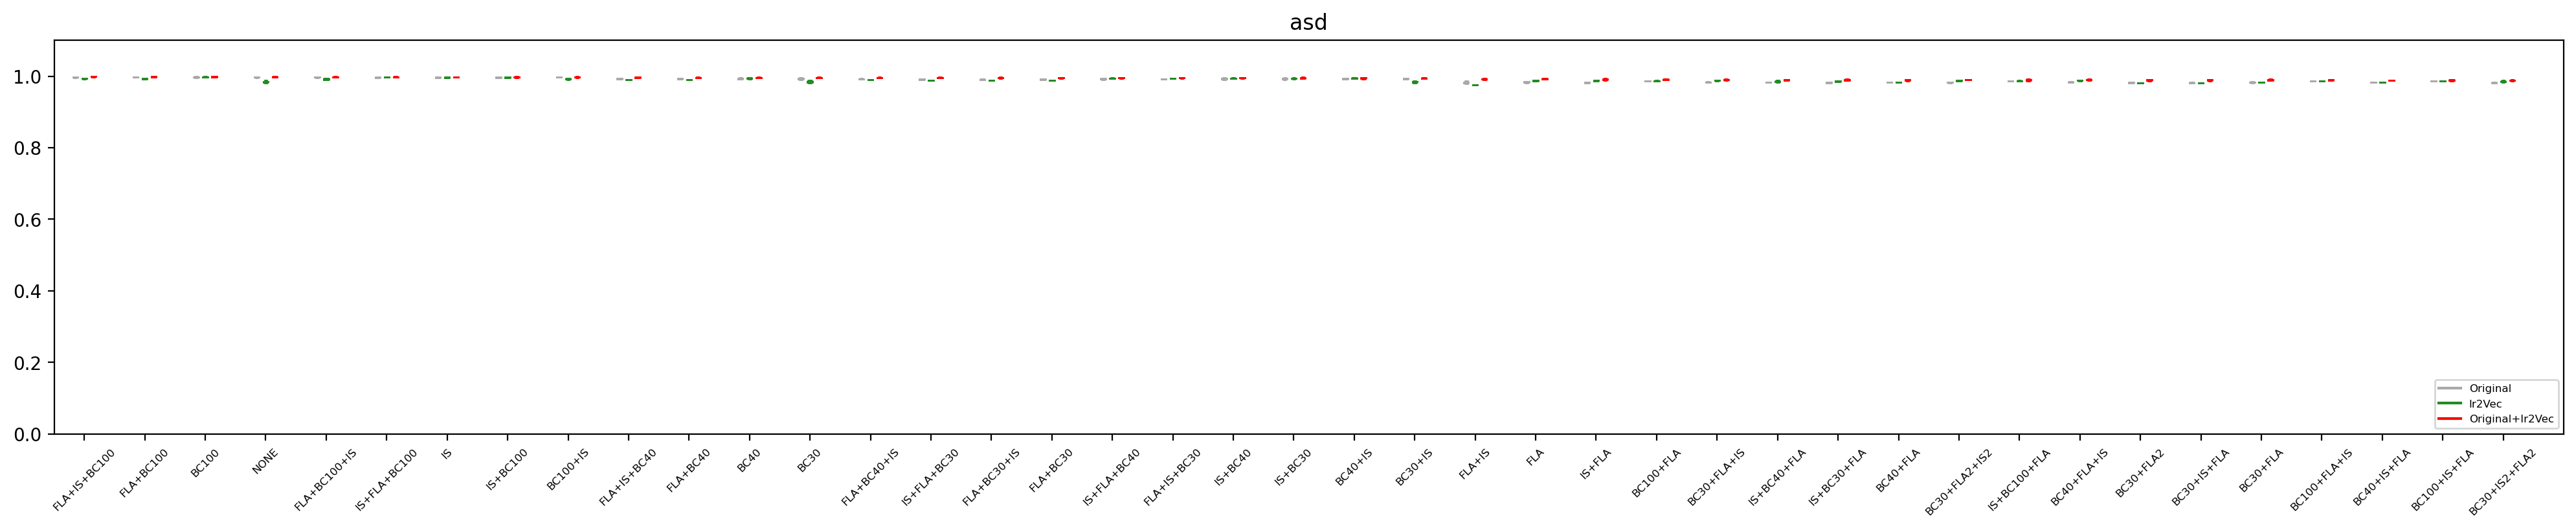

In [155]:
data_values = [data_values_original, data_values_ir2vec, data_values_tf_idf_plus_ir2vec]
draw_plot(data_labels, data_values, 'asd', 'asasd')

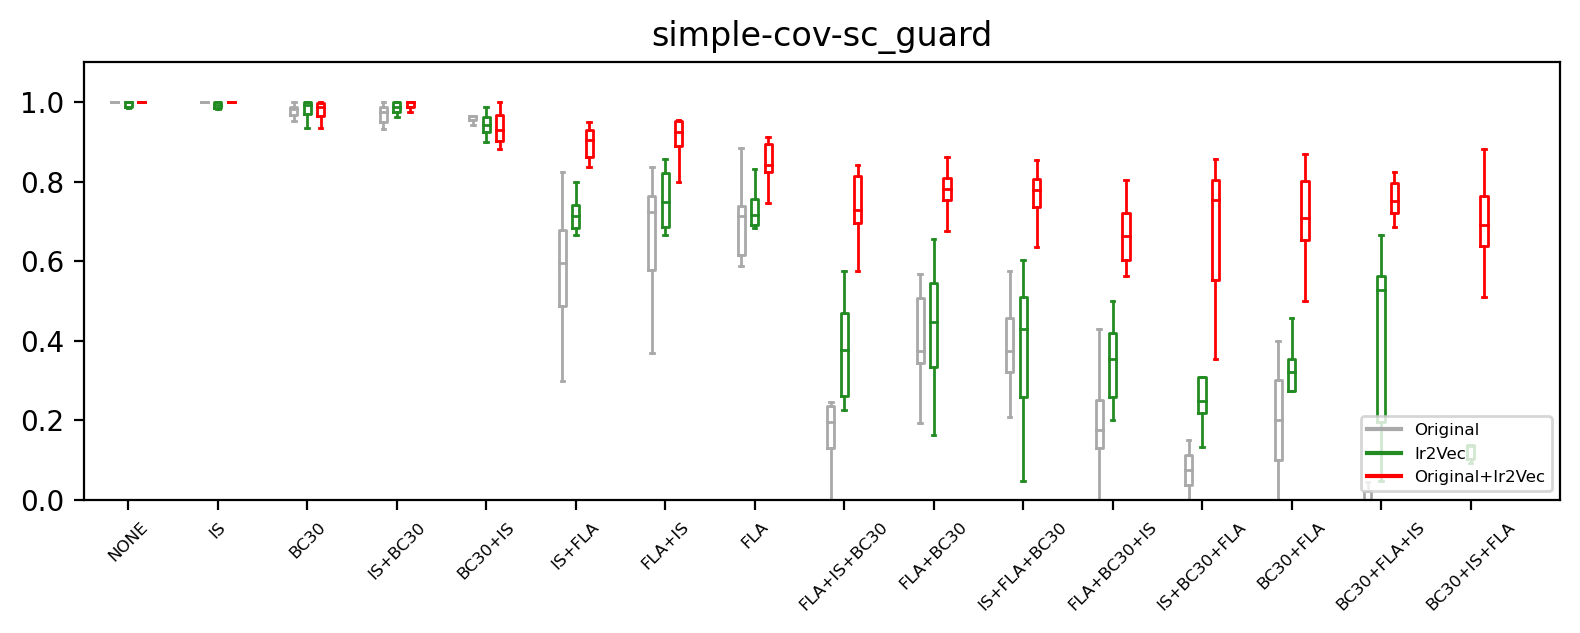

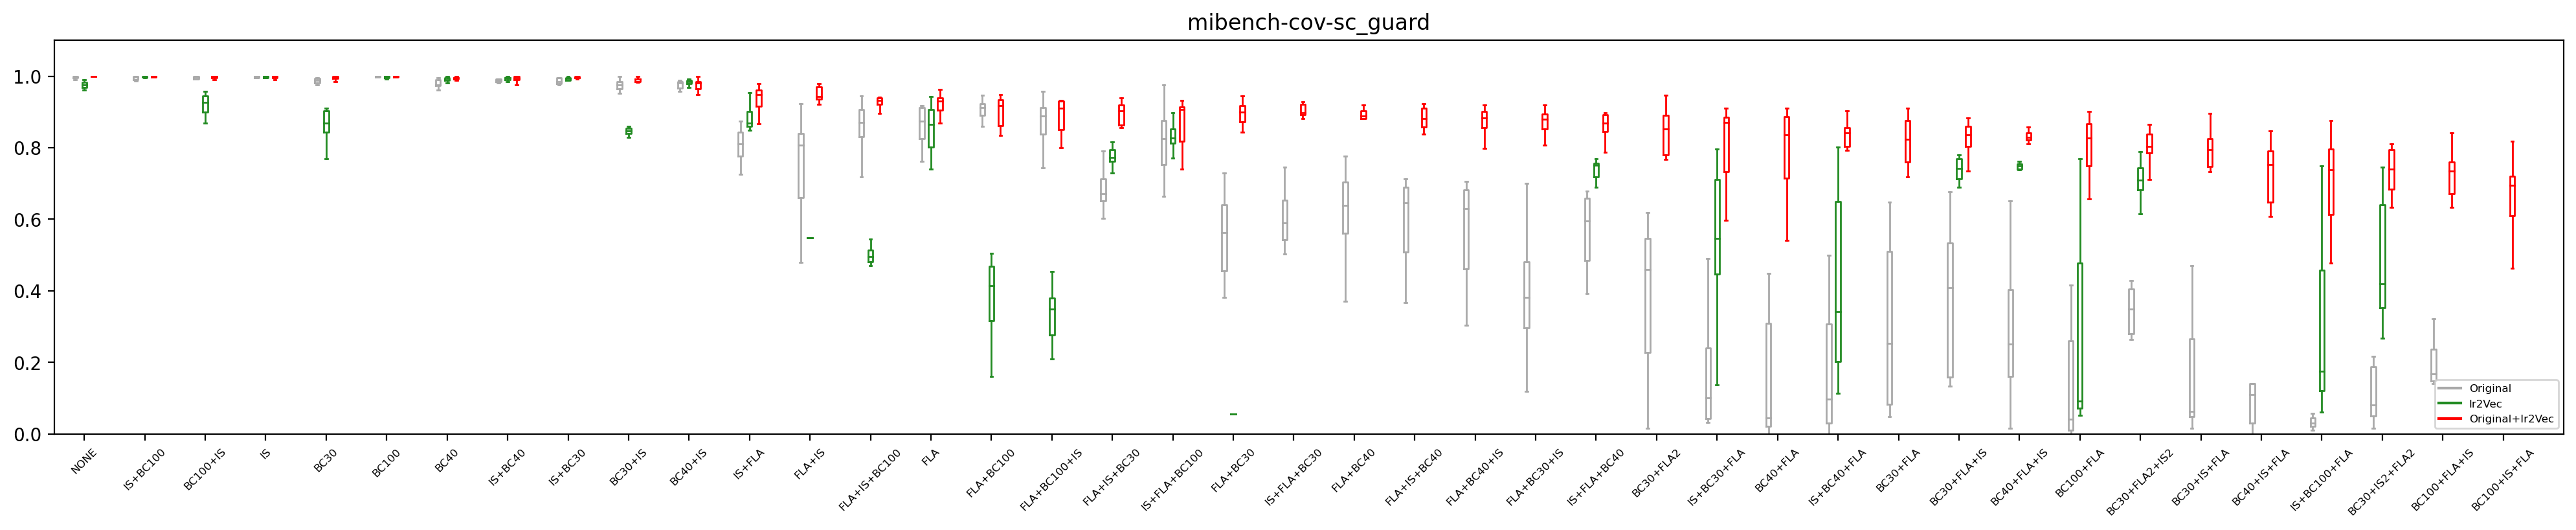

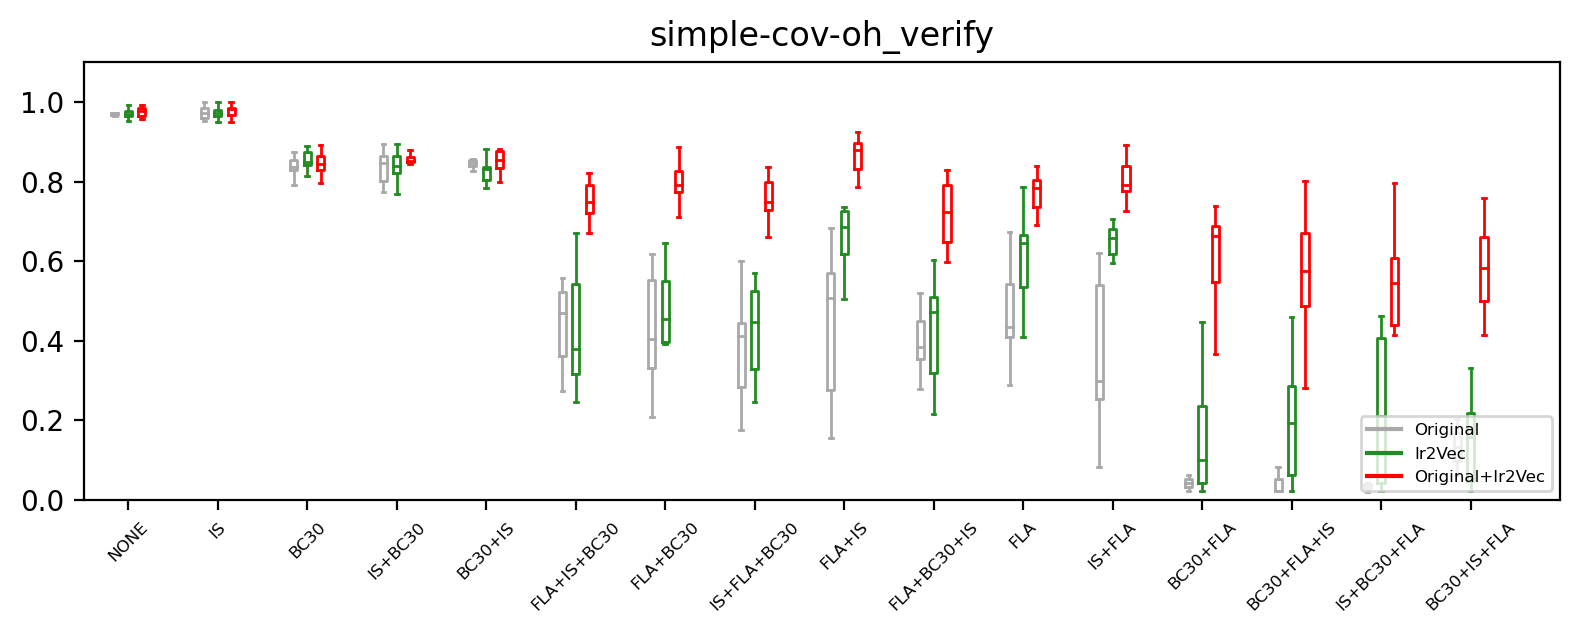

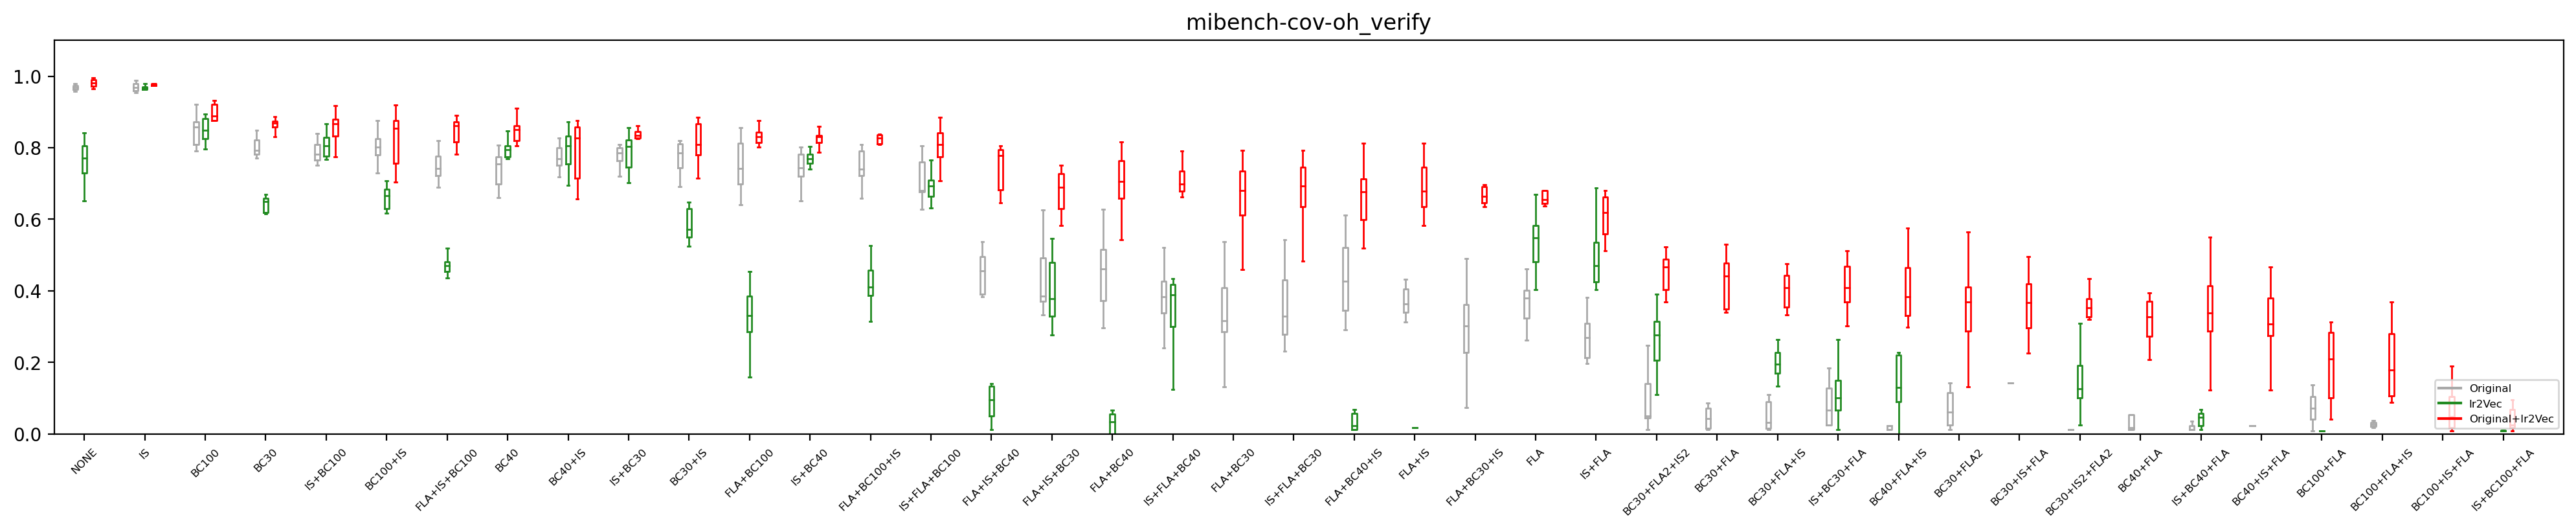

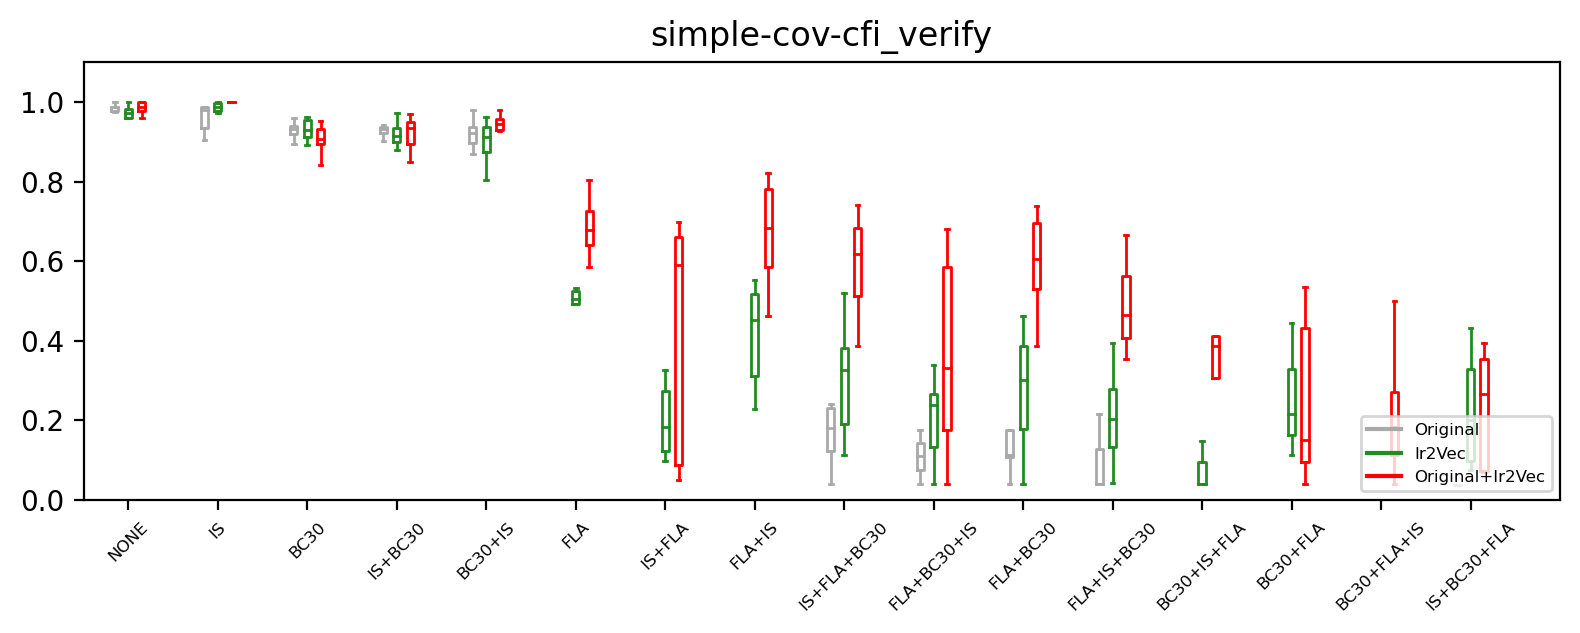

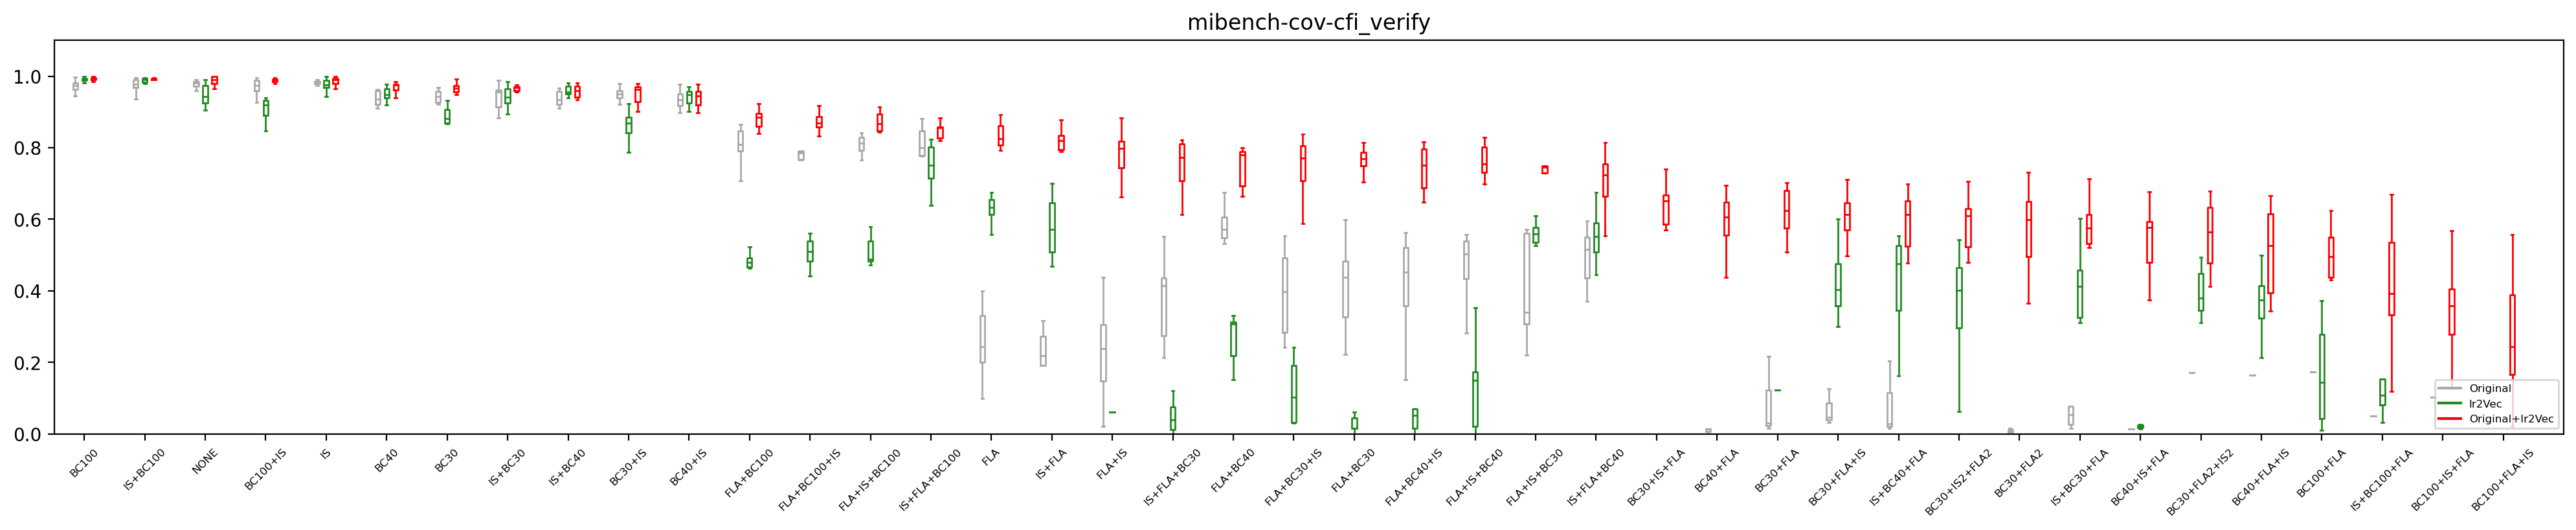

In [56]:
for protection in ['sc_guard', 'oh_verify', 'cfi_verify']:
    mibench_plot_results = get_plot_results(results_data, protection, 'mibench-cov')
    mibench_data_labels = sorted(
        mibench_plot_results.keys(), 
        key=lambda key: median(mibench_plot_results[key]['tf_idf_plus_ir2vec']),
        reverse=True
    )
    
    for src_dataset in ['simple-cov', 'mibench-cov']:
        plot_results = get_plot_results(results_data, protection, src_dataset)
        
        data_labels = sorted(plot_results.keys(), key=lambda key: mibench_data_labels.index(key) if key in mibench_data_labels else len(mibench_data_labels))
        data_values_original = [plot_results[label]['original'] for label in data_labels]
        data_values_ir2vec = [plot_results[label]['ir2vec'] for label in data_labels]
        data_values_tf_idf_plus_ir2vec = [plot_results[label]['tf_idf_plus_ir2vec'] for label in data_labels]
        
        plot_title = f'{src_dataset}-{protection}'
        file_name = f'plots/{plot_title}.pdf'
        data_values = [data_values_original, data_values_ir2vec, data_values_tf_idf_plus_ir2vec]
        draw_plot(data_labels, data_values, plot_title, file_name)

## Tabular Results

In [67]:
import pandas as pd

In [63]:
def mean(arr):
    return sum(arr) / len(arr) if len(arr) > 0 else None

In [133]:
dataframes = {}
for src_dataset in ['simple-cov', 'mibench-cov']:
    data = {}
    for protection in ['sc_guard', 'oh_verify', 'cfi_verify']:
        plot_results = get_plot_results(results_data, protection, src_dataset)
        for obfs in plot_results:
            for features in plot_results[obfs]:
                values = plot_results[obfs][features]
                plot_results[obfs][features] = mean(values)
        data[protection] = pd.DataFrame(plot_results).T
    dataframes[f'{src_dataset}'] = pd.concat(data, axis=1)

In [148]:
labels = """
None
BC
BC+CFF
BC+CFF+IS
BC+IS
BC+IS+CFF
CFF
CFF+BC
CFF+BC+IS
CFF+IS
CFF+IS+BC
IS
IS+BC
IS+BC+CFF
IS+CFF
IS+CFF+BC
""".strip().split()

dataframes['simple-cov'].reindex([
    'NONE', 'BC30', 'BC30+FLA', 'BC30+FLA+IS', 'BC30+IS', 'BC30+IS+FLA', 'FLA', 'FLA+BC30', 'FLA+BC30+IS',
    'FLA+IS', 'FLA+IS+BC30', 'IS', 'IS+BC30', 'IS+BC30+FLA', 'IS+FLA', 'IS+FLA+BC30'
])

sc_guard                              oh_verify            \
             original    ir2vec tf_idf_plus_ir2vec  original    ir2vec   
NONE         0.998413  0.995287           0.998413  0.973040  0.969172   
BC30         0.979661  0.982409           0.979831  0.839325  0.854227   
BC30+FLA     0.200000  0.308126           0.695497  0.041454  0.160289   
BC30+FLA+IS  0.076180  0.411613           0.746952  0.041604  0.195631   
BC30+IS      0.959502  0.942874           0.934640  0.848492  0.829289   
BC30+IS+FLA  0.000000  0.190351           0.695338  0.133431  0.143807   
FLA          0.654718  0.691039           0.846027  0.446847  0.611492   
FLA+BC30     0.408370  0.433257           0.767338  0.421780  0.429280   
FLA+BC30+IS  0.194369  0.349340           0.666905  0.407584  0.426230   
FLA+IS       0.661476  0.754790           0.911980  0.449151  0.663741   
FLA+IS+BC30  0.191098  0.375128           0.708814  0.444695  0.422163   
IS           0.998462  0.992060           0.996875  0.973846  0.968192   
IS+BC30      0.964206  0.985299           0.993887  0.837326  0.840911   
IS+BC30+FLA  0.075472  0.277747           0.666209  0.032692  0.248483   
IS+FLA       0.540813  0.715891           0.896400  0.365639  0.658010   
IS+FLA+BC30  0.381359  0.376353           0.767670  0.373174  0.429847   

                               cfi_verify                               
            tf_idf_plus_ir2vec   original    ir2vec tf_idf_plus_ir2vec  
NONE                  0.975139   0.983530  0.969158           0.986865  
BC30                  0.848720   0.929310  0.931453           0.908890  
BC30+FLA              0.602644        NaN  0.257313           0.253753  
BC30+FLA+IS           0.565089        NaN       NaN           0.212283  
BC30+IS               0.850259   0.921311  0.901723           0.939119  
BC30+IS+FLA           0.584528        NaN  0.075275           0.356476  
FLA                   0.773699   0.000000  0.494220           0.685354  
FLA+BC30              0.793972   0.154259  0.279714           0.598640  
FLA+BC30+IS           0.720919   0.108337  0.212225           0.368746  
FLA+IS                0.866469        NaN  0.421172           0.673163  
FLA+IS+BC30           0.742791   0.098200  0.213592           0.469763  
IS                    0.977996   0.960192  0.984169           0.997436  
IS+BC30               0.856601   0.928630  0.919428           0.923457  
IS+BC30+FLA           0.513462   0.037037  0.226713           0.231375  
IS+FLA                0.801835        NaN  0.237805           0.425909  
IS+FLA+BC30           0.756509   0.165522  0.308436           0.587864

In [150]:
dataframes['mibench-cov']

sc_guard                              oh_verify            \
               original    ir2vec tf_idf_plus_ir2vec  original    ir2vec   
BC30+FLA+IS    0.389626  0.729231           0.824048  0.051040  0.198101   
FLA+IS+BC100   0.852971  0.499230           0.933219  0.739267  0.474143   
FLA+BC30+IS    0.390431       NaN           0.871661  0.285735  0.000000   
IS+FLA+BC40    0.544818  0.734837           0.859131  0.394696  0.346394   
FLA+IS+BC40    0.570042       NaN           0.881373  0.452288  0.086405   
NONE           0.996251  0.975142           0.998942  0.964560  0.764159   
IS+BC100       0.995002  0.997607           0.994152  0.786536  0.808296   
FLA+BC100+IS   0.853314  0.336668           0.889543  0.736590  0.420559   
IS+FLA+BC100   0.800245  0.831655           0.868581  0.711566  0.686886   
FLA            0.850864  0.853644           0.923160  0.368684  0.521732   
BC100+IS       0.996299  0.914641           0.997345  0.803651  0.645052   
FLA+IS         0.752973  0.548077           0.943701  0.382894  0.016667   
BC30+IS        0.970205  0.844619           0.987810  0.774997  0.567515   
IS+FLA         0.789823  0.883912           0.936813  0.272955  0.495205   
BC100+IS+FLA        NaN       NaN           0.647929       NaN       NaN   
BC30+FLA       0.297035       NaN           0.798423  0.045478       NaN   
FLA+BC30       0.525895  0.054795           0.886042  0.334375  0.000000   
BC40           0.979756  0.991757           0.994030  0.739405  0.778925   
IS             0.997867  0.998407           0.997354  0.966474  0.961777   
IS+FLA+BC30    0.583414       NaN           0.897908  0.354194  0.000000   
BC30+IS+FLA    0.168102       NaN           0.779358  0.142012       NaN   
BC100+FLA      0.142717  0.267851           0.802080  0.072348  0.008368   
IS+BC100+FLA   0.032698  0.297129           0.698476       NaN  0.010443   
FLA+BC40+IS    0.564009       NaN           0.872783  0.436123  0.033719   
FLA+IS+BC30    0.660740  0.781165           0.878107  0.439397  0.404428   
IS+BC30+FLA    0.162757  0.541789           0.811685  0.085728  0.114358   
BC40+FLA       0.164970       NaN           0.792724  0.048511       NaN   
BC30           0.987020  0.863765           0.995938  0.791626  0.616388   
BC40+IS        0.973035  0.981840           0.975809  0.765378  0.795786   
BC40+FLA+IS    0.297837  0.742444           0.828715  0.024873  0.134899   
BC30+IS2+FLA2  0.162771  0.479331           0.699340  0.012195  0.140956   
IS+BC40        0.985871  0.993451           0.993015  0.743934  0.769236   
FLA+BC40       0.619787  0.000000           0.886998  0.455784  0.031033   
IS+BC30        0.986091  0.990363           0.996731  0.773631  0.785837   
FLA+BC100      0.907569  0.382507           0.900103  0.748526  0.317628   
BC100+FLA+IS   0.176285       NaN           0.699082  0.026990       NaN   
BC100          0.998411  0.997352           0.996584  0.827553  0.843965   
BC30+FLA2+IS2  0.323014  0.708387           0.791500  0.097288  0.259358   
BC30+FLA2      0.385157       NaN           0.820773  0.070948       NaN   
BC40+IS+FLA    0.147457       NaN           0.725713  0.023529       NaN   
IS+BC40+FLA    0.173689  0.405412           0.811945  0.019425  0.041410   

                                 cfi_verify                               
              tf_idf_plus_ir2vec   original    ir2vec tf_idf_plus_ir2vec  
BC30+FLA+IS             0.417718   0.068259  0.387301           0.610731  
FLA+IS+BC100            0.844480   0.809123  0.509323           0.856109  
FLA+BC30+IS             0.681430   0.392670  0.119591           0.727077  
IS+FLA+BC40             0.701223   0.496032  0.519898           0.700616  
FLA+IS+BC40             0.741909   0.473939  0.129990           0.761831  
NONE                    0.980059   0.971917  0.946584           0.987058  
IS+BC100                0.855120   0.976063  0.988491           0.987845  
FLA+BC100+IS            0.809669   0.780535  0.505894           0.87026